In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/childes_mi.pickle')

In [6]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_words,n_unique_words
0,"[6.0615547382637684, 5.953026573946322, 5.8999...","[0.06497202939114834, 0.06421181443545038, 0.0...","[5.79799893493386, 5.805771966570329, 5.792474...","[0.06474471004074468, 0.06537742978608413, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2371,72
1,"[10.373016081368098, 10.130972857078175, 9.987...","[0.00937963690006051, 0.009307961610168364, 0....","[9.60947032947951, 9.60572819037825, 9.5994570...","[0.009097935454051041, 0.009124346562127784, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,67747,3609
2,"[11.349881924265677, 11.087999639009142, 10.96...","[0.005174827403727939, 0.005136394630766223, 0...","[10.681207621740015, 10.677630292519837, 10.67...","[0.005060342080401666, 0.005066649080465537, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.5,2,232191,8134


In [7]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [8]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    
    sig = sig
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]

    print(row.age_cohort_low, row.age_cohort_high, best_fit_model)

/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))


0.5 1 exp
1.0 1.5 pow_exp
1.5 2 pow_exp
2.0 2.5 pow_exp
2.5 3 pow_exp
3.0 20 pow_exp



In [9]:
MI_DF

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_words,n_unique_words,exp_results,...,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[6.0615547382637684, 5.953026573946322, 5.8999...","[0.06497202939114834, 0.06421181443545038, 0.0...","[5.79799893493386, 5.805771966570329, 5.792474...","[0.06474471004074468, 0.06537742978608413, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.5,1,2371,72,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.803612,0.804922,0.776286,-136.562178,-132.408084,-127.833763,exp,"[-3.6367098727388944e-06, -5.463370893703798e-...",NaN
1,"[10.373016081368098, 10.130972857078175, 9.987...","[0.00937963690006051, 0.009307961610168364, 0....","[9.60947032947951, 9.60572819037825, 9.5994570...","[0.009097935454051041, 0.009124346562127784, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.0,1.5,67747,3609,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.960713,0.986984,0.980082,-420.636087,-526.718807,-488.563146,pow_exp,"[6.528048763553539e-07, 9.767024895467008e-07,...",450.0
2,"[11.349881924265677, 11.087999639009142, 10.96...","[0.005174827403727939, 0.005136394630766223, 0...","[10.681207621740015, 10.677630292519837, 10.67...","[0.005060342080401666, 0.005066649080465537, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.5,2,232191,8134,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.949823,0.989080,0.985398,-360.792506,-505.839244,-481.766416,pow_exp,"[9.60855604404184e-07, 1.4398265135829119e-06,...",435.0
3,"[12.421599707857368, 12.124559687616102, 11.99...","[0.0033293605141089407, 0.0032982717697735654,...","[11.756060854089633, 11.754715776334926, 11.75...","[0.003259500059111028, 0.003261010542536753, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2.0,2.5,656639,14402,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.974186,0.996492,0.991567,-429.445717,-624.641943,-541.319049,pow_exp,"[1.116469991993569e-06, 1.6691921956434772e-06...",375.0
4,"[11.532466104026422, 11.247538669418567, 11.12...","[0.004322162033098881, 0.004289030213930944, 0...","[10.928431808392926, 10.926159127779197, 10.92...","[0.004249227382651435, 0.0042542569785092525, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2.5,3,422922,9336,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.954515,0.985079,0.980663,-349.189828,-455.142679,-433.869505,pow_exp,"[-7.656782712802456e-07, -1.1602581095676295e-...",317.0
5,"[13.90350042312788, 13.60402662450543, 13.4863...","[0.0016126379123154566, 0.001596772378812455, ...","[13.344836093986757, 13.344052969455305, 13.34...","[0.0015852035484411658, 0.001585418309044302, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3.0,20,3210842,43208,<lmfit.minimizer.MinimizerResult object at 0x7...,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.957765,0.988433,0.983562,-309.589767,-429.516198,-400.182416,pow_exp,"[6.813220961528881e-07, 1.0079629675508996e-06...",335.0


In [16]:
MI_DF.concat_results.values[0].params

Parameters([('e_init',
             <Parameter 'e_init', value=0.2550403875165519 +/- 0.23, bounds=[1e-19:inf]>),
            ('e_decay_const',
             <Parameter 'e_decay_const', value=0.3112004936620467 +/- 0.0767, bounds=[1e-10:inf]>),
            ('p_init',
             <Parameter 'p_init', value=0.07322019378836941 +/- 0.169, bounds=[1e-10:inf]>),
            ('p_decay_const',
             <Parameter 'p_decay_const', value=-2.8258570644944325 +/- 16, bounds=[-inf:-1e-10]>),
            ('intercept',
             <Parameter 'intercept', value=0.003211441724368491 +/- 0.000709, bounds=[1e-10:inf]>)])

In [17]:
test = MI_DF.concat_results.values[0].params['p_decay_const']
test

<Parameter 'p_decay_const', value=-2.8258570644944325 +/- 16, bounds=[-inf:-1e-10]>

In [18]:
test.stderr

15.988565223346768

In [28]:
param = 'p_decay_const'

In [29]:
powerlaw_slope = np.array([i.params[param].value for i in MI_DF.concat_results.values])
powerlaw_slope_stderr = np.array([i.params[param].stderr for i in MI_DF.concat_results.values])

In [30]:
labels = ['6-12 months', '12-18 months', '18-24 months', '24-30 months', '30-36 months', '3-4 years']

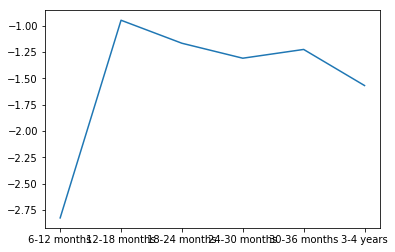

In [31]:
plt.plot(labels, powerlaw_slope)
#plt.fill_between(labels, powerlaw_slope - powerlaw_slope_stderr, powerlaw_slope + powerlaw_slope_stderr, alpha = 0.2)